# `problink` Example notebook
This notebook provides an example of running the `problink` code on a mock data set.

### Define functions for Mock data set

In [1]:
import numpy as np
import problink
import problink.xidmod as xidmod
import pylab as plt
%matplotlib inline

#### Age
Looking at the [ECFSPR annual data report for 2015](https://www.ecfs.eu/sites/default/files/general-content-images/working-groups/ecfs-patient-registry/ECFSPR_Report2015_Nov2017.pdf), the distribution of ages can be approximated with a truncated exponential distribution, with a location of 0.0, scale of 20 and truncated at an age of 80.

In [2]:
def generate_age(no):
    from scipy.stats import truncexpon
    loc=0
    scale=20    
    age_y1=truncexpon.rvs(4,loc=loc,scale=scale,size=no)
    return age_y1,age_y1+1

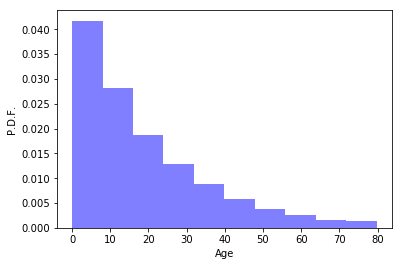

In [3]:
age_y1,age_y2=generate_age(10000)
plt.hist(age_y1,normed=True,color='blue',alpha=0.5);
plt.xlabel('Age');
plt.ylabel('P.D.F.');

#### Height
For height, we can express the percentile each patient is on in regard to standard height curves.
CF patients tend to be shorter due to malnutrition, so we move the distribution to be centered on the 40th percentile and truncate it at 0.0. We expect each patient's percentile to vary with each year, with a Gaussian distribution, with Sigma=2

In [4]:
def hgt_percentile(size):
    from scipy.stats import truncnorm, norm
    a, b = (5 - 40) / 34.0, (95 - 40.0) / 34.0
    hgt_pc=truncnorm.rvs(a,b,loc=40,scale=34,size=size)
    return hgt_pc, hgt_pc+norm.rvs(0,2,size=size)

#### BMI
For BMI, we can express the percentile each patient is on in regard to the BMI curves in Boelle et al. 2012.
Percentiles are therefore distributed with the normal distribution. We expect each patient's percentile to vary with each year, with a Gaussian distribution, with Sigma=2.

In [5]:
def bmi_percentile(size):
    from scipy.stats import truncnorm, norm
    a, b = (5 - 50) / 34.0, (95 - 50.0) / 34.0
    bmi_pc=truncnorm.rvs(a,b,loc=50,scale=34,size=size)
    return bmi_pc, bmi_pc+norm.rvs(0,2,size=size)

#### Gender

In [6]:
def gender(size):
    from scipy import stats
    xk = np.arange(1,3)
    pk = (0.5,0.5)
    custm = stats.rv_discrete(name='custm', values=(xk, pk))
    gend=custm.rvs(size=size)
    return gend

#### Mutation
We treat CF mutations in 6 classes: 'df508 df508', 'df508 other', 'df508 unknown', 'other other', 'other unknown', 'unknown unknown', with probabilities of each determined by ECFSPR reports. For the mock data, we will base the probabilities of each class from a 2008 snapshot of the ECFSPR containing numerous countries.

In [7]:
def mutation(size):
    import problink
    import problink.xidmod as xidmod
    pk=xidmod.load_mut_pdf()
    from scipy import stats
    xk = np.arange(pk.size)
    custm = stats.rv_discrete(name='custm', values=(xk, pk))
    mut=custm.rvs(size=size)
    lab= np.array([['[delta]F508', '[delta]F508'],['[delta]F508', 'other'],['[delta]F508', 'unknown'],['other','other'],['other', 'unknown'],['unknown','unknown']])
    return lab[mut,:]

#### Age at Diagnosis

In [8]:
def age_diag(size):
    return np.full((size),-1)

### Generate Mock dataset

In [23]:
no=1000
age_y1,age_y2=generate_age(no)
hgt_y1,hgt_y2=hgt_percentile(no)
bmi_y1,bmi_y2=bmi_percentile(no)
sex=gender(no)
geno=mutation(no)
status=np.full((no),0.0)
age_dia=age_diag(no)
for i in range(0,no):
    xidmod.BMI_model_curve(bmi_y1[i],[age_y1[i]],sex[i])[0]
    bmi_y1[i]=xidmod.BMI_model_curve(bmi_y1[i],[age_y1[i]],sex[i])[0]
    bmi_y2[i]=xidmod.BMI_model_curve(bmi_y2[i],[age_y2[i]],sex[i])[0]
    hgt_y1[i]=xidmod.hgt_model(hgt_y1[i],[age_y1[i]],sex[i])[0]
    hgt_y2[i]=xidmod.hgt_model(hgt_y2[i],[age_y2[i]],sex[i])[0]
dob_j=np.empty((no),dtype=long)
for i in range(0,no):
    dob_j[i]=np.int(((2016-np.floor(age_y1[i])-1900)*12)+np.ceil((age_y1[i]-np.floor(age_y1[i]))*12))

In [46]:
ind=(age_y1<10) & (age_y1>5)

#### Give data to problink data class

In [51]:
data_y1=problink.data(bmi_y1[ind], hgt_y1[ind], np.arange(0,no)[ind], dob_j[ind],sex[ind],geno.T[:,ind], age_dia[ind],status[ind],2016)
data_y2=problink.data(bmi_y2[ind], hgt_y2[ind], np.arange(0,no)[ind], dob_j[ind],sex[ind],geno.T[:,ind], age_dia[ind],status[ind],2017)

In [50]:
ind.sum()

192

#### Generate prior information and run probabilisitic linkage

In [52]:
prior=problink.prior()
results=problink.link(prior,data_y1,data_y2)

[ ==========================================================  ] 98.31%

The output from `problink.prior` is an array, size (8, number of made links). It contains the log Bayes factor for each variable, the probability of match and the IDs of the linked patients:

| $\ln B_{gender}$ | $\ln B_{BMI}$ | $\ln B_{height}$ | $\ln B_{age}$ | $\ln B_{geno}$ | Probability of match. | ID1 | ID2 |
| --- | --- | --- |--- | --- | --- |--- | --- |

